In [1]:
import requests
import statistics 
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import datetime 
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.style as style; style.use('fivethirtyeight')

In [2]:
url = 'https://api.covid19india.org/data.json'
r1 = requests.get(url)
dictr1 = r1.json()
#print(dictr1)

In [3]:
df_india = pd.DataFrame(dictr1['cases_time_series'])
#df_india


In [4]:
df_india['date_new'] = pd.date_range(start='30-1-2020', periods=len(df_india), freq='D')
df_india['date_new'] = df_india['date_new'].dt.date

df_new=df_india

In [5]:
df_new['totalconfirmed'] = pd.to_numeric(df_new['totalconfirmed'])
df_new['totalrecovered'] = pd.to_numeric(df_new['totalrecovered'])
df_new['totaldeceased'] = pd.to_numeric(df_new['totaldeceased'])

In [6]:
#adding X(t-1) new column to data frame

df_new['X_tminus1'] = df_new['totalconfirmed'].shift(1)
df_new['X_tminus1_death'] = df_new['totaldeceased'].shift(1)

In [7]:
#calculating L_t
df_new['L_t']=df_new['totalconfirmed']/df_new['X_tminus1']
df_new['L_t_death']=df_new['totaldeceased']/df_new['X_tminus1_death']

In [8]:
df_new=df_new[73:]
df_new

,dailyconfirmed,dailydeceased,dailyrecovered,date,dateymd,totalconfirmed,totaldeceased,totalrecovered,date_new,X_tminus1,X_tminus1_death,L_t,L_t_death
73,758,42,114,12 April,2020-04-12,9211,332,1086,2020-04-12,8453.0,290.0,1.089672,1.144828
74,1243,27,112,13 April,2020-04-13,10454,359,1198,2020-04-13,9211.0,332.0,1.134947,1.081325
75,1031,37,167,14 April,2020-04-14,11485,396,1365,2020-04-14,10454.0,359.0,1.098623,1.103064
76,886,27,144,15 April,2020-04-15,12371,423,1509,2020-04-15,11485.0,396.0,1.077144,1.068182
77,1061,26,258,16 April,2020-04-16,13432,449,1767,2020-04-16,12371.0,423.0,1.085765,1.061466
...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,45928,491,53312,01 November,2020-11-01,8229245,122050,7542738,2020-11-01,8183317.0,121559.0,1.005612,1.004039
277,37592,498,58524,02 November,2020-11-02,8266837,122548,7601262,2020-11-02,8229245.0,122050.0,1.004568,1.004080
278,46027,510,53328,03 November,2020-11-03,8312864,123058,7654590,2020-11-03,8266837.0,122548.0,1.005568,1.004162
279,50465,707,55873,04 November,2020-11-04,8363329,123765,7710463,2020-11-04,8312864.0,123058.0,1.006071,1.005745


In [9]:
list_L_t=df_new['L_t'].tolist()
list_L_t_death=df_new['L_t_death'].tolist()
list_date=df_new['date_new'].tolist()

#storing day count in days list
days=[]
for i in range(len(list_date)):
    days.append(i+1);

In [10]:
from scipy.optimize import curve_fit 

def lin(t,m,c):
    return m*t+c
#setting initial parameters
m=-1
c=1.3
g=[-1,1.3]

n=len(days)
t = np.array(days)
lt=df_new['L_t'].values
#lt_death=df_new['L_t_death'].values

#finding parameters of line
param, param_cov = curve_fit(lin,t,lt, g)
#param_death, param_death_cov = curve_fit(lin,t,lt_death, g)

print('paramater for cummulative positive cases',param)
#print('paramater for cummulative death',param_death)

#for extrpolation
extrapolation_till=230
line_till_day=list(range(extrapolation_till))
extrapo_line=np.array(line_till_day)

y=np.empty(len(extrapo_line))
#y_death=np.empty(len(extrapo_line))
for i in range (len(extrapo_line)):
    y[i]=lin(line_till_day[i],param[0],param[1])
    #y_death[i]=lin(line_till_day[i],param_death[0],param_death[1])

paramater for cummulative positive cases [-3.33557052e-04  1.06882519e+00]


In [11]:
#ploting point when it reaches 1.001
point_when=(1.001-param[1])/param[0]
print('day when L(t) reaches 1.001=',point_when)

day when L(t) reaches 1.001= 203.33909090952653


In [12]:
#customization of dates for plotting the data
date_window=20
cus_date=[]
j=0
k=[]
for d in list_date:
    if j<len(list_date):
        cus_date.append(list_date[j])
        k.append(j)
        j=j+date_window
    elif d==list_date[-1]:
        cus_date.append(list_date[-1])
        k.append(len(list_date))
if extrapolation_till>len(list_date):
    delta = datetime.timedelta(days = date_window)
    last_date=list_date[-1]
    for i in range((extrapolation_till-len(list_date))//date_window):
        
        last_date = last_date + delta
        k.append(k[-1]+date_window)
        cus_date.append(last_date)
        
        
        
#print(k) 
#print(cus_date)

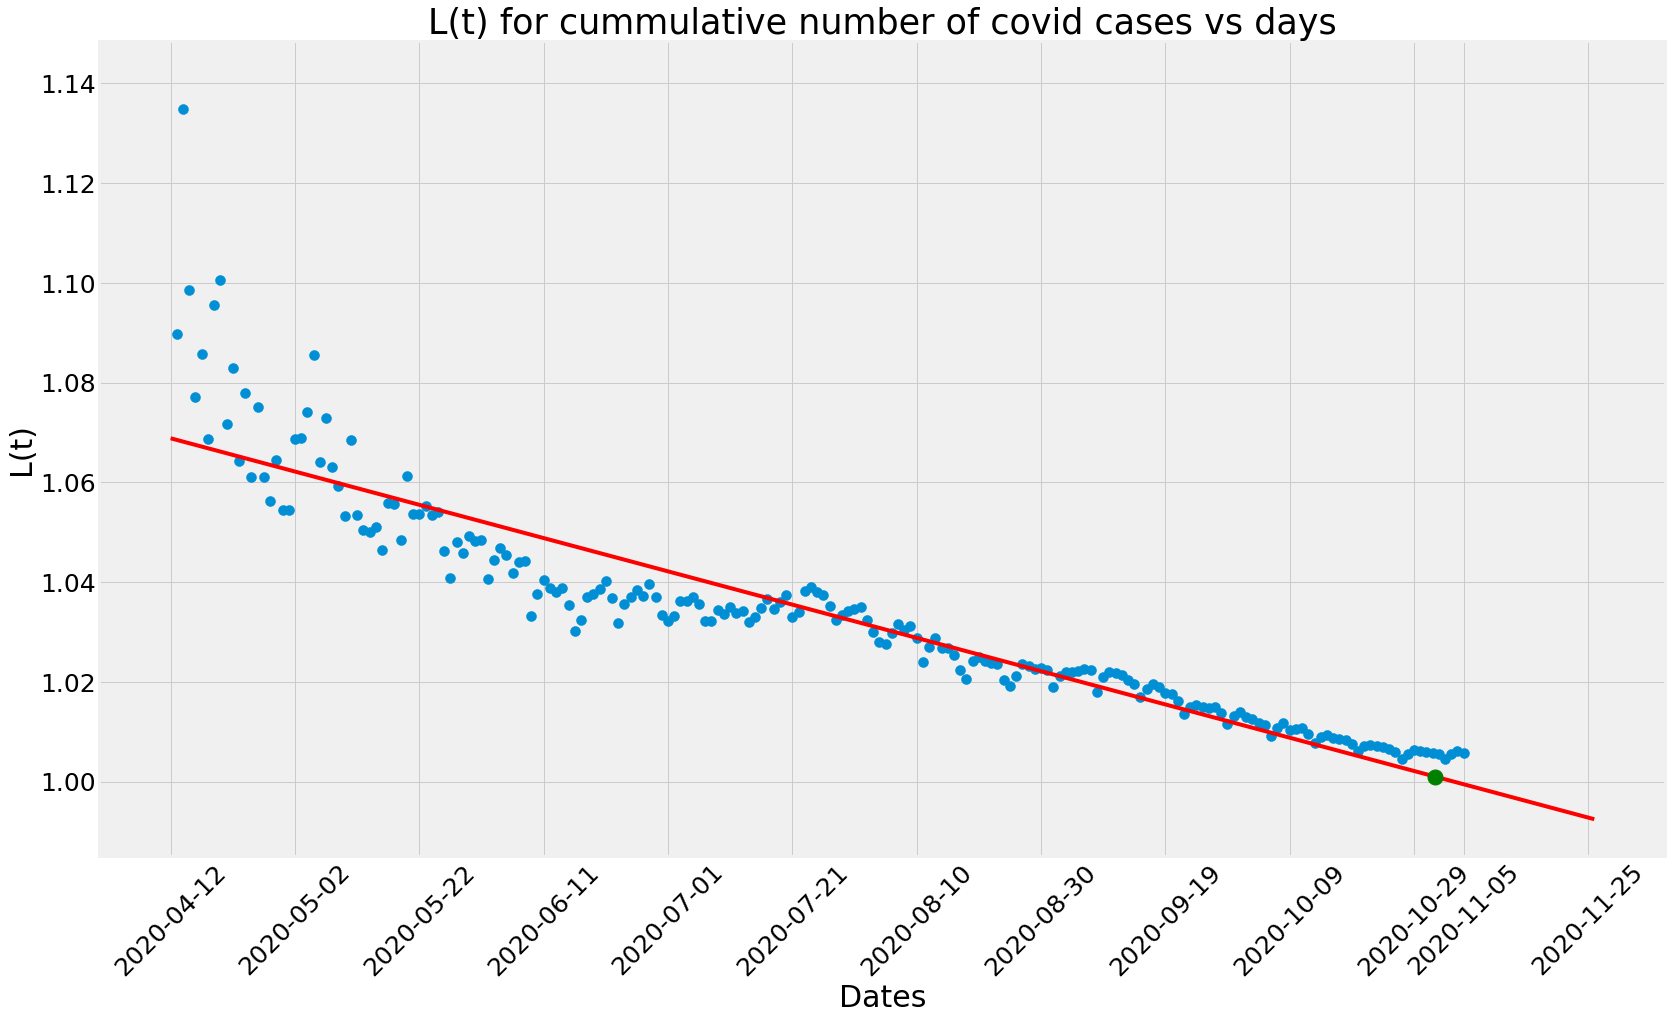

In [13]:
#plotting graph
plt.figure(figsize= (25,15))
plt.scatter(t, list_L_t, s=100)
plt.xticks(k,cus_date,fontsize=25, rotation=45)
plt.yticks(np.arange(0, 5, step=0.02),fontsize=25)

plt.plot(extrapo_line,y,'r')
plt.plot(point_when,1.001,'go', markersize=15)
#plt.rc('font', size=25) 
#plt.rc('axes', titlesize=25) 
plt.title("L(t) for cummulative number of covid cases vs days", fontsize=35)
plt.ylabel("L(t)", fontsize=30)
plt.xlabel("Dates",fontsize=30)


plt.show()

In [14]:
lt_death=df_new['L_t_death'].values

param_death, param_death_cov = curve_fit(lin,t,lt_death, g)
print('paramater for cummulative death',param_death)
y_death=np.empty(len(extrapo_line))

for i in range (len(extrapo_line)):
    y_death[i]=lin(line_till_day[i],param_death[0],param_death[1])

paramater for cummulative death [-3.35203231e-04  1.06490063e+00]


In [15]:
#ploting poin when it reaches 1.001
point_when_death=(1.001-param_death[1])/param_death[0]
print(point_when_death)

190.6324879737586


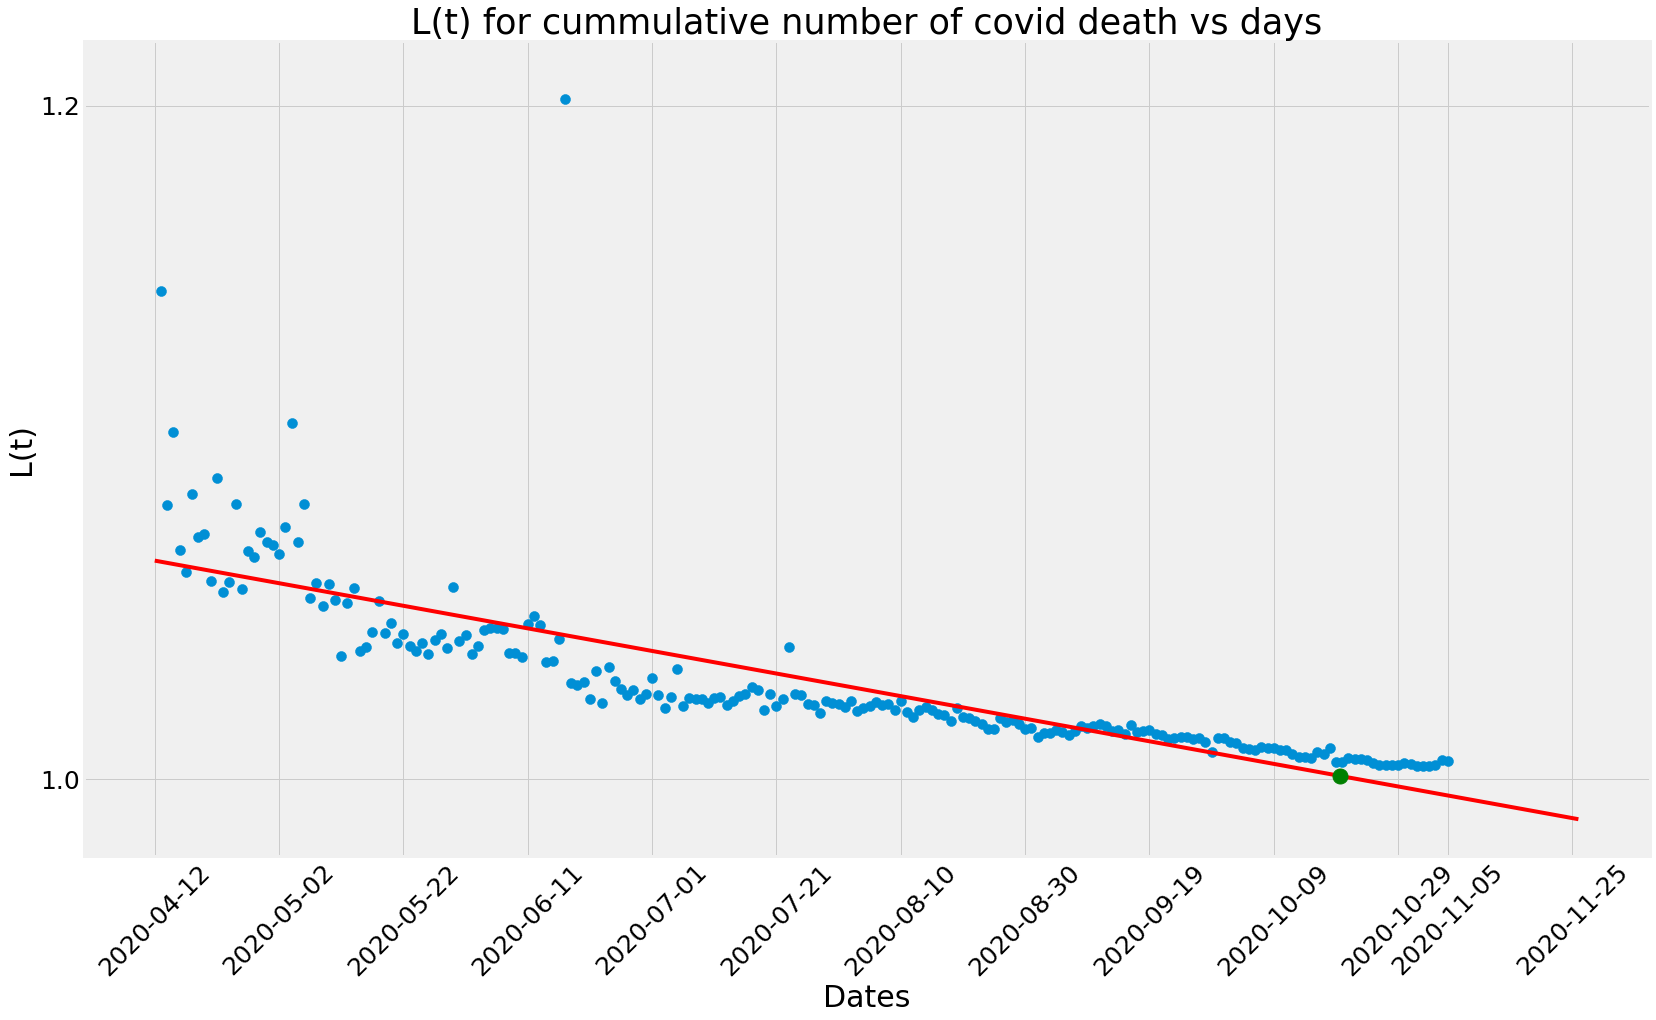

In [16]:
#plotting graph for cummulative death
plt.figure(figsize= (25,15))
plt.scatter(t, list_L_t_death, s=100)
plt.xticks(k,cus_date,fontsize=25, rotation=45)
plt.yticks(np.arange(0, 5, step=0.2),fontsize=25)

plt.plot(extrapo_line,y_death,'r')
plt.plot(point_when_death,1.001,'go', markersize=15)

#plt.rc('font', size=25) 
#plt.rc('axes', titlesize=25) 
plt.title("L(t) for cummulative number of covid death vs days", fontsize=35)
plt.ylabel("L(t)", fontsize=30)
plt.xlabel("Dates",fontsize=30)


plt.show()